In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import datetime
import skimage.draw
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


''' replace config and utils with new files'''
'''
from mrcnn.config import Config
from mrcnn import model as modellib, utils
'''
sys.path.append(os.path.join(ROOT_DIR,"mrcnn")) 
print(sys.path)
from mrcnn.insects_config import Config
from mrcnn import insects_utils as utils

from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log



# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")




from samples.insects import train_insects as insects

%matplotlib inline 


# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
INSECTS_WEIGHTS_PATH = "/data/CoRoSect/10.code/maskRCNN/Mask_RCNN_matterport/mask_rcnn_balloon.h5"  # TODO: update this path


['/home/melissap/miniconda3/envs/kumar/lib/python36.zip', '/home/melissap/miniconda3/envs/kumar/lib/python3.6', '/home/melissap/miniconda3/envs/kumar/lib/python3.6/lib-dynload', '', '/home/melissap/miniconda3/envs/kumar/lib/python3.6/site-packages', '/home/melissap/miniconda3/envs/kumar/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg', '/home/melissap/miniconda3/envs/kumar/lib/python3.6/site-packages/IPython/extensions', '/home/melissap/.ipython', '/data/CoRoSect/10.code/maskRCNN/Mask_RCNN_matterport', '/data/CoRoSect/10.code/maskRCNN/Mask_RCNN_matterport/mrcnn']
['/home/melissap/miniconda3/envs/kumar/lib/python36.zip', '/home/melissap/miniconda3/envs/kumar/lib/python3.6', '/home/melissap/miniconda3/envs/kumar/lib/python3.6/lib-dynload', '', '/home/melissap/miniconda3/envs/kumar/lib/python3.6/site-packages', '/home/melissap/miniconda3/envs/kumar/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg', '/home/melissap/miniconda3/envs/kumar/lib/python3.6/site-packages/IPython/extensions

Using TensorFlow backend.


In [2]:
config = insects.InsectsConfig()
INSECTS_DIR = os.path.join(ROOT_DIR, "mask_rcnn/datasets/Nasekomo_insects")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
# Load validation dataset
dataset = insects.InsectsDataset()
dataset.load_subset(INSECTS_DIR, "valid")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


PREPARE prints : 
numclasses2
classids
[0 1]
classnames
['BG', 'insects']
numimages
63
imageids
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Images: 63
Classes: ['BG', 'insects']


In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [8]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /data/CoRoSect/10.code/maskRCNN/Mask_RCNN_matterport/logs/insects20220214T1132/mask_rcnn_insects_0026.h5






Re-starting from epoch 26


image ID: insects.1_340001.jpg (3) /data/CoRoSect/10.code/maskRCNN/Mask_RCNN_matterport/mask_rcnn/datasets/Nasekomo_insects/1/trainvalid/1_340001.jpg
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
gt_class_id              shape: (13,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (13, 4)               min:   17.00000  max:  112.00000  int32
gt_mask                  shape: (128, 128, 13)        min:    0.00000  max:    1.00000  bool
(562, 1000, 3)


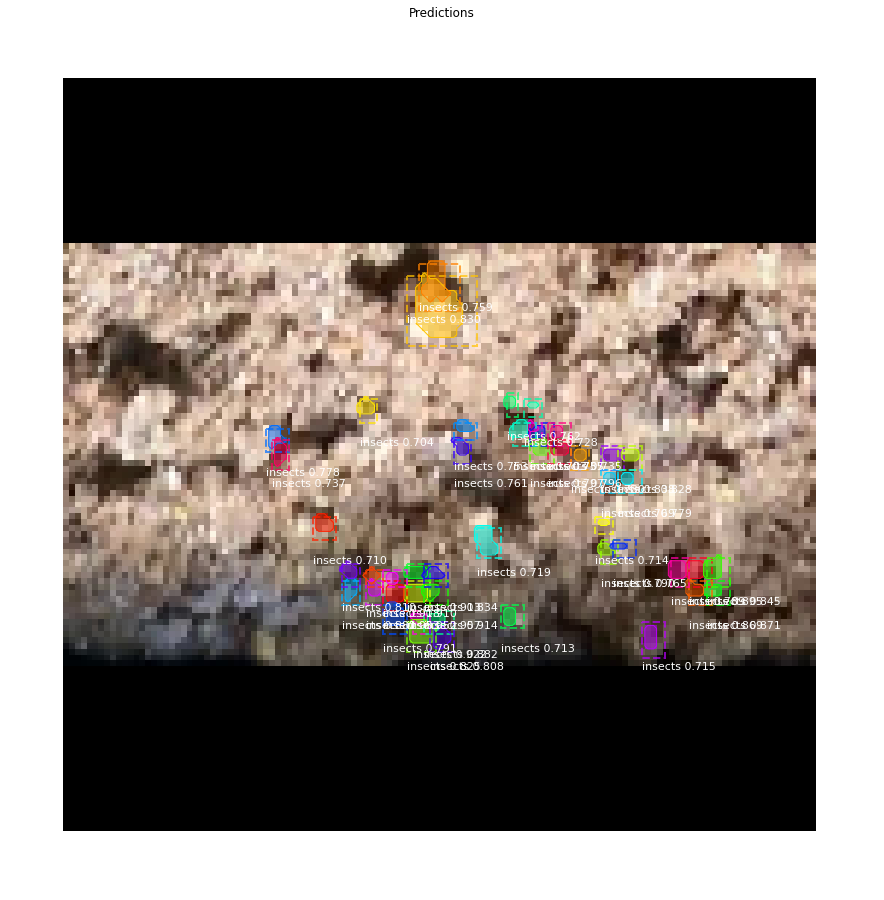

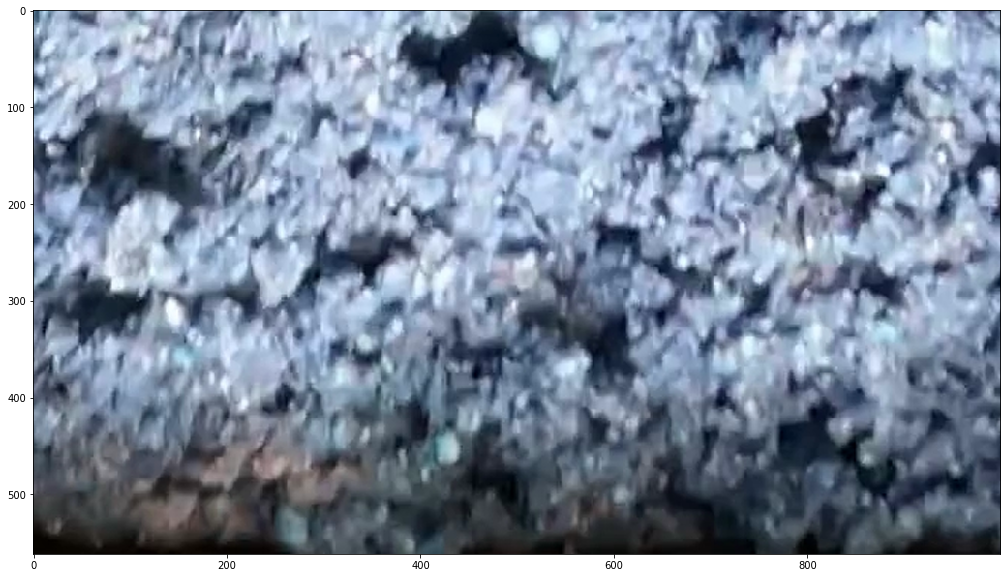

In [86]:
########################################
def show_image(impath):
    origin_im=cv2.imread(impath)
    #print(origin_im.shape)
    origin_im=cv2.resize(origin_im,(1000,562),interpolation=cv2.INTER_CUBIC)
    print(origin_im.shape)
    plt.figure(figsize = (20,10))
    plt.imshow(origin_im, interpolation='nearest')
    plt.show()

image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#Show the original image
origin_im_path = dataset.image_reference(image_id)
show_image(origin_im_path)